In [44]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import random
import cv2
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle


## Data Preparation and resize image

In [23]:
no_tb_data = "E:\\Download\\TB_Chest_Radiography_Database\\Normal"
tb_data = "E:\\Download\\TB_Chest_Radiography_Database\\Tuberculosis"


In [24]:
X_yes = []
for image in tqdm(os.listdir(tb_data)):
    image_path = os.path.join(tb_data, image)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224,224))
    X_yes.append(img)

100%|██████████| 700/700 [00:08<00:00, 86.63it/s]


In [25]:
x_yes = np.array(X_yes)

In [26]:
datagen = ImageDataGenerator(rotation_range=20,width_shift_range=0.2, height_shift_range=0.2,horizontal_flip=True,fill_mode='nearest')
aug_images = []
for image in tqdm(x_yes):
    image = np.expand_dims(image,axis=0)
    i = 0
    for batch in datagen.flow(image,batch_size=1):
        aug_images.append(batch[0])
        i += 1
        if i >= 5:
            break
        

100%|██████████| 700/700 [00:28<00:00, 24.68it/s]


In [27]:
TB_yes = []
for image in tqdm(aug_images):
    TB_yes.append([image,1])

100%|██████████| 3500/3500 [00:00<00:00, 1156092.61it/s]


In [28]:
X_no = []
for image in tqdm(os.listdir(no_tb_data)):
    image_path = os.path.join(no_tb_data,image)
    img = cv2.imread(image_path)
    img = cv2.resize(img,(224,224))
    X_no.append(img)

  0%|          | 0/3500 [00:00<?, ?it/s]

100%|██████████| 3500/3500 [00:40<00:00, 86.76it/s]


In [29]:
TB_no = []
for image in tqdm(X_no):
    TB_no.append([image,0])

100%|██████████| 3500/3500 [00:00<00:00, 1752843.46it/s]


In [30]:
data = TB_yes + TB_no

In [31]:
random.shuffle(data)

In [32]:
X = []
Y = []
for i,j in tqdm(data):
    X.append(i)
    Y.append(j)

100%|██████████| 7000/7000 [00:00<00:00, 1552460.24it/s]


In [33]:
x = np.array(X)
y = np.array(Y)

## Train Data

In [34]:
x_train = x[:5500]
y_train = y[:5500]

## Test Data

In [35]:
x_test = x[5500:7000]
y_test = y[5500:7000]

## Model

In [36]:
model = Sequential()

model.add(Conv2D(100,(3,3), activation="relu", input_shape = (224,224,3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(100,(3,3),activation="relu"))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64,(3,3), activation= "relu"))

model.add(Conv2D(64,(3,3), activation= "relu"))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(64, activation= "relu"))
model.add(Dropout(.2))
model.add(Dropout(.3))
model.add(Dense(32, activation= "relu"))
model.add(Dense(1, activation= "sigmoid"))

model.compile(optimizer="adam", loss='binary_crossentropy',metrics=['accuracy'])

c:\Users\MSI_PC\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Training

In [37]:
history = model.fit(x_train,y_train,validation_split=.2,epochs = 5)


Epoch 1/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.7294 - loss: 3.8502 - val_accuracy: 0.9045 - val_loss: 0.3455
Epoch 2/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.9168 - loss: 0.2784 - val_accuracy: 0.6945 - val_loss: 1.4563
Epoch 3/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.8104 - loss: 0.8365 - val_accuracy: 0.9200 - val_loss: 0.2906
Epoch 4/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.8996 - loss: 0.3765 - val_accuracy: 0.9500 - val_loss: 0.1928
Epoch 5/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.9304 - loss: 0.2149 - val_accuracy: 0.9309 - val_loss: 0.2002


## Loss and Accuracy


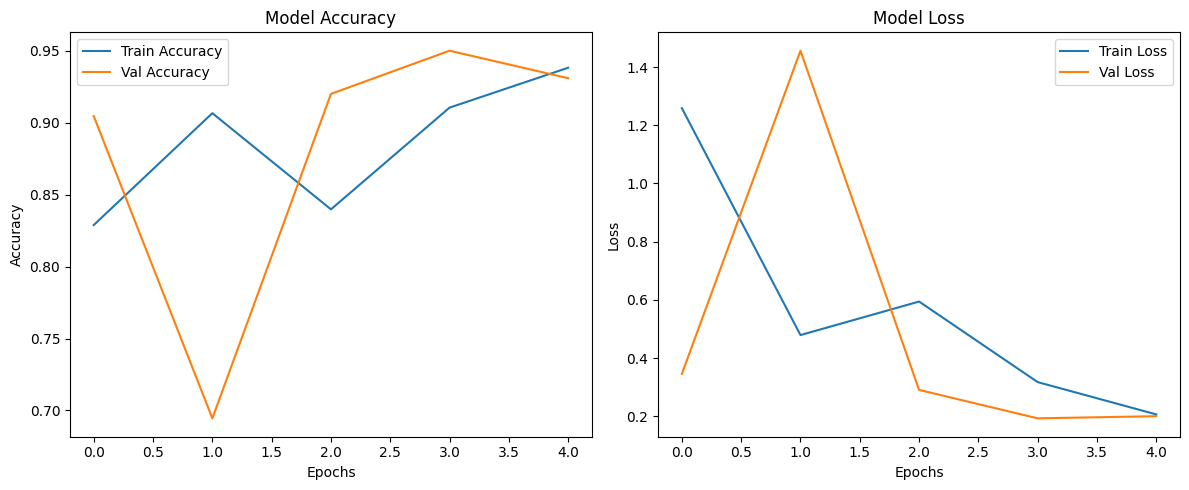

In [38]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Confution Matrix

In [39]:
threshold = 0.5
y_pred = (model.predict(x_test)>= threshold).astype(int)

47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 476ms/step


<Figure size 1200x1000 with 0 Axes>

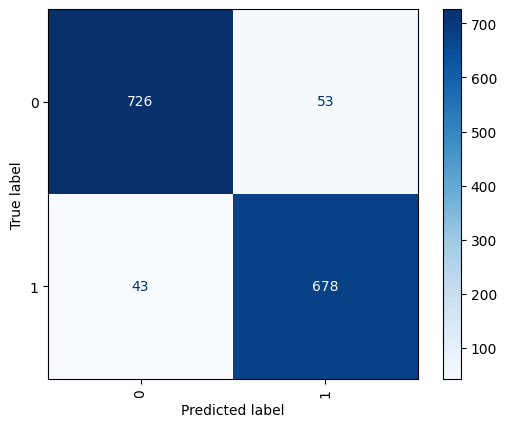

In [40]:
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(12,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['0','1'])
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

## Model Evaluation

In [41]:
model.evaluate(x_test,y_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 435ms/step - accuracy: 0.9352 - loss: 0.2102


[0.21608103811740875, 0.9359999895095825]

In [42]:
history_test = model.fit(x_test,y_test,validation_split=.2,epochs = 5)

Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8557 - loss: 0.3709 - val_accuracy: 0.9533 - val_loss: 0.1219
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9381 - loss: 0.1911 - val_accuracy: 0.9500 - val_loss: 0.1458
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9522 - loss: 0.1637 - val_accuracy: 0.9667 - val_loss: 0.0857
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9608 - loss: 0.1053 - val_accuracy: 0.9533 - val_loss: 0.1247
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9592 - loss: 0.1191 - val_accuracy: 0.9733 - val_loss: 0.0861


In [43]:
model.evaluate(x_train,y_train)

172/172 ━━━━━━━━━━━━━━━━━━━━ 72s 420ms/step - accuracy: 0.9720 - loss: 0.1104


[0.10132534056901932, 0.9714545607566833]

## Save model

In [45]:
with open('hasil_model_1.pkl','wb') as file:
    pickle.dump(model,file)
print('model berhasil disimpan ke file ','hasil_model_1.pkl')

model berhasil disimpan ke file  hasil_model_1.pkl
